Linearization and discretization

In [1]:
import numpy as np
from planar_quadrotor import linearize_and_discretize, MASS, GRAVITY

x_eq = np.array([0, 0, 0, 0, 0, 0])
u_eq = np.array([MASS * GRAVITY / 2, MASS * GRAVITY / 2])
dt = 0.01

Ad, Bd = linearize_and_discretize(x_eq, u_eq, dt)

print(f"Ad:\n{Ad}")
print(f"Bd:\n{Bd}")


Ad:
[[ 1.000e+00  1.000e-02  0.000e+00  0.000e+00 -4.905e-04 -1.635e-06]
 [ 0.000e+00  1.000e+00  0.000e+00  0.000e+00 -9.810e-02 -4.905e-04]
 [ 0.000e+00  0.000e+00  1.000e+00  1.000e-02  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.000e+00  1.000e-02]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
Bd:
[[-5.45000000e-09  5.45000000e-09]
 [-2.18000000e-06  2.18000000e-06]
 [ 8.33333333e-05  8.33333333e-05]
 [ 1.66666667e-02  1.66666667e-02]
 [ 6.66666667e-05 -6.66666667e-05]
 [ 1.33333333e-02 -1.33333333e-02]]


Set constraints

In [2]:
lb_x = np.array([
    -5.0,          # x min
    -3.0,          # vx min
    -5.0,          # y min
    -3.0,          # vy min
    -np.deg2rad(30),   # theta min (-30°)
    -np.deg2rad(180)   # omega min (-180°/s)
])

ub_x = np.array([
     5.0,          # x max
     3.0,          # vx max
     5.0,          # y max
     3.0,          # vy max
     np.deg2rad(30),    # theta max (+30°)
     np.deg2rad(180)    # omega max (+180°/s)
])


lb_u = np.array([
    0.0,    # u_left min
    0.0     # u_right min
])


ub_u = np.array([
    12,   # u_left max
    12   # u_right max
])


lb_x_tilde = lb_x - x_eq
ub_x_tilde = ub_x - x_eq
lb_u_tilde = lb_u - u_eq
ub_u_tilde = ub_u - u_eq

Regulation

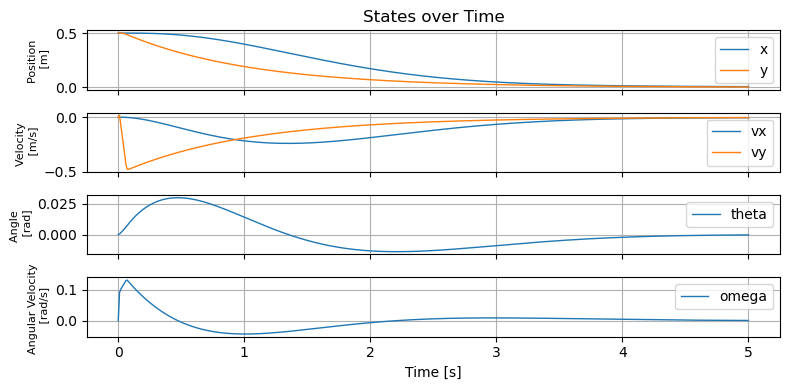

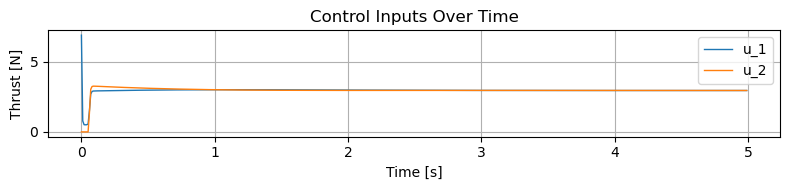

In [3]:
from terminal_set import compute_terminal_set
from  simulation import simulate_mpc_regulation,plot_mpc_regulation


Q = np.array([[100.0, 0., 0., 0., 0., 0.], 
              [0., 100.0, 0., 0., 0., 0.], 
              [0., 0., 100.0, 0., 0., 0.], 
              [0., 0., 0., 100.0, 0., 0.], 
              [0., 0., 0., 0., 100.0, 0.], 
              [0., 0., 0., 0., 0., 1000.0]])


R = np.array([[0.01, -0], [0, 0.01]])

A_inf, b_inf,P_inf, K = compute_terminal_set(
    Ad, Bd,
    lb_x_tilde, ub_x_tilde,
    lb_u_tilde, ub_u_tilde,
    Q, R,
    max_iter=50
)

N = 6
N_sim = 500
x0 = np.array([0.5, 0, 0.5, 0, 0, 0])
dt = 0.01


x_hist, u_hist,_=simulate_mpc_regulation(N, N_sim, x0, x_eq, u_eq,
                                        Ad, Bd, Q, R, P_inf,
                                        lb_u, ub_u,
                                        lb_x, ub_x,
                                        A_inf, b_inf,
                                        dt)


plot_mpc_regulation(x_hist, u_hist, N_sim, dt)




Regulation under different Q

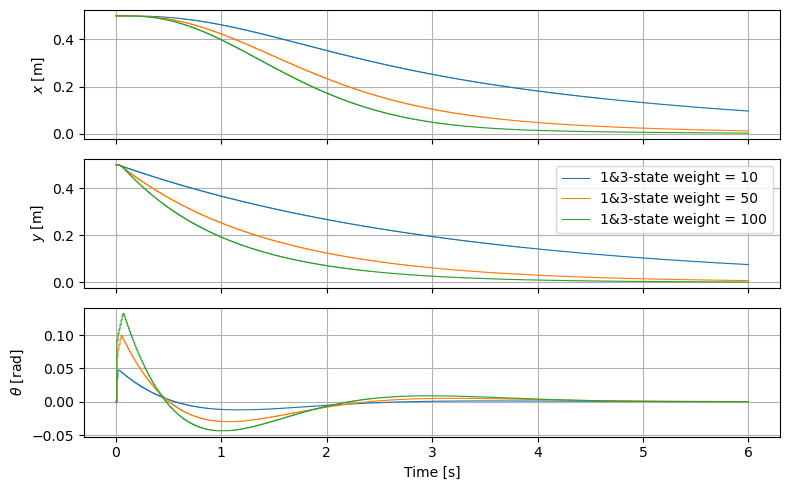

In [4]:
from simulation import compare_regulation_by_Q

N = 6 #predition horizon
x0 = np.array([0.5, 0, 0.5,0,0, 0])
N_sim = 600#time step


Q_list = [
    np.diag([10, 100, 10, 100, 100, 1000]),
    np.diag([50, 100,50, 100, 100, 1000]),
    np.diag([100, 100, 100, 100, 100, 1000])
]


labels = ['1&3-state weight = 10', '1&3-state weight = 50', '1&3-state weight = 100']
colors = ['tab:blue', 'tab:orange', 'tab:green']


compare_regulation_by_Q(N, N_sim, x0, Q_list, labels, colors,
                               x_eq, u_eq,
                               Ad, Bd, R,
                               lb_u, ub_u,
                               lb_x, ub_x)



Regulation under different R

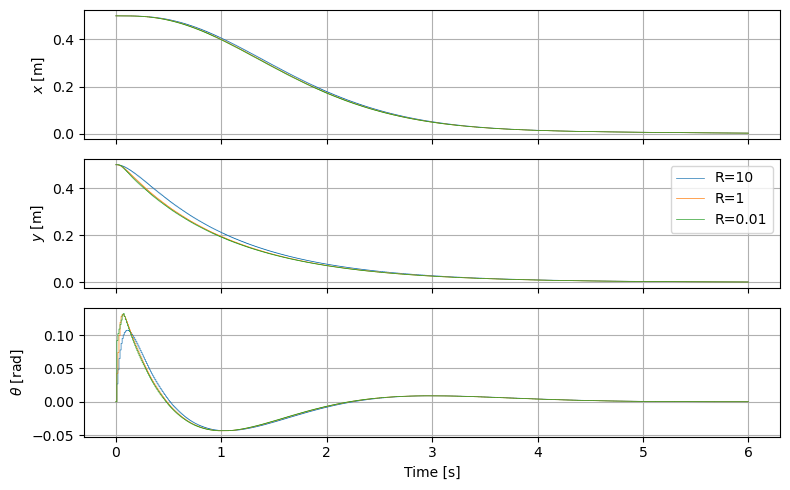

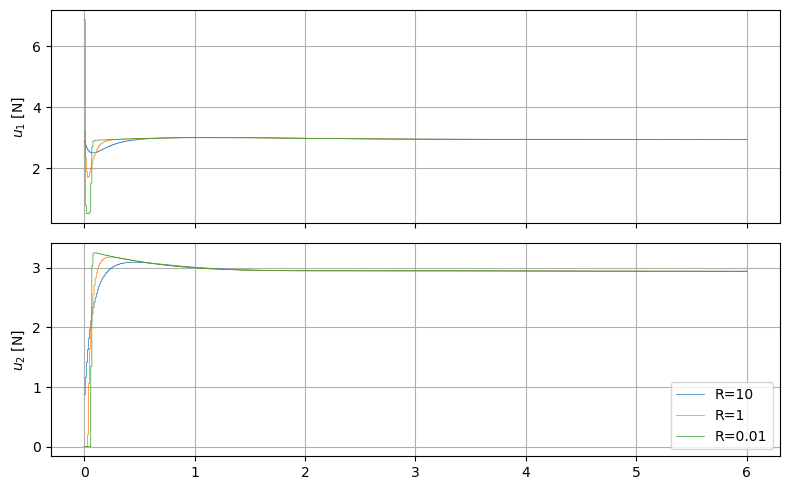

In [5]:
import matplotlib.pyplot as plt
from simulation import compare_regulation_by_R

Q = np.array([[100.0, 0., 0., 0., 0., 0.], 
              [0., 100.0, 0., 0., 0., 0.], 
              [0., 0., 100.0, 0., 0., 0.], 
              [0., 0., 0., 100.0, 0., 0.], 
              [0., 0., 0., 0., 100.0, 0.], 
              [0., 0., 0., 0., 0., 1000.0]])


N = 6 #predition horizon
x0 = np.array([0.5, 0, 0.5,0,0, 0])


N_sim = 600#time step


R_list = [
    np.array([[10, 0.], [0, 10]]),
    np.array([[1, 0.], [0., 1]]),
    np.array([[0.01, 0.], [0., 0.01]])
]

labels = ['R=10', 'R=1', 'R=0.01']
colors = ['tab:blue', 'tab:orange', 'tab:green']


compare_regulation_by_R(N, N_sim, x0, Q, R_list, labels, colors,
                              x_eq, u_eq,
                              Ad, Bd,
                              lb_u, ub_u,
                              lb_x, ub_x)




Comparison of LQR and MPC controller

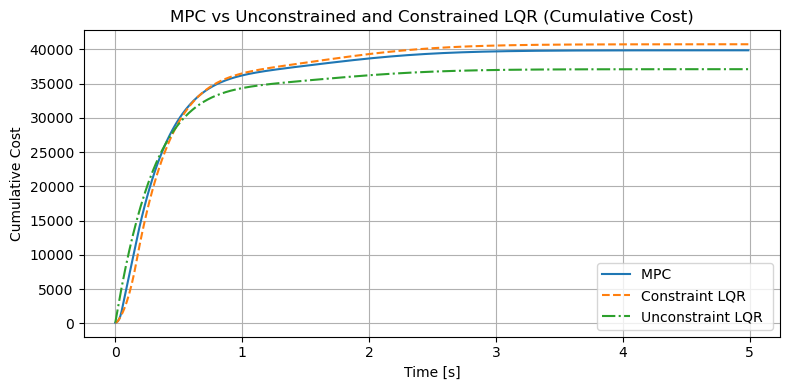

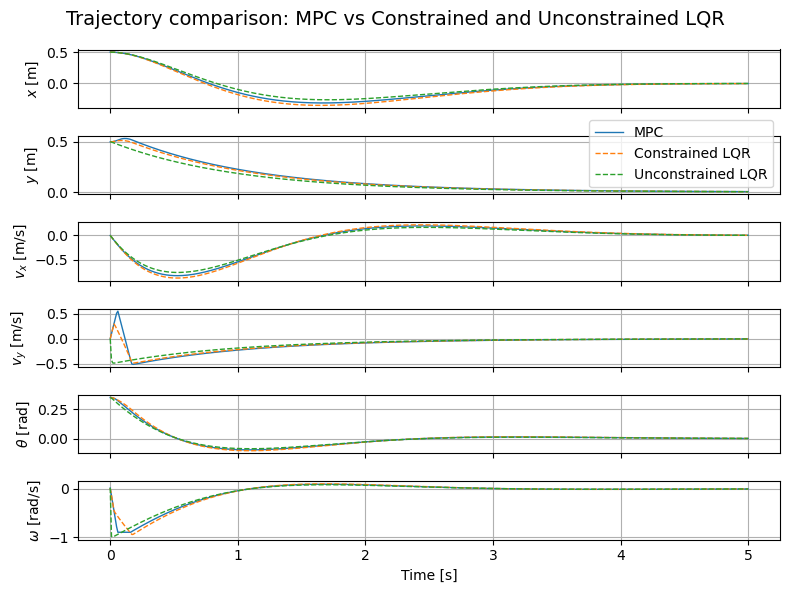

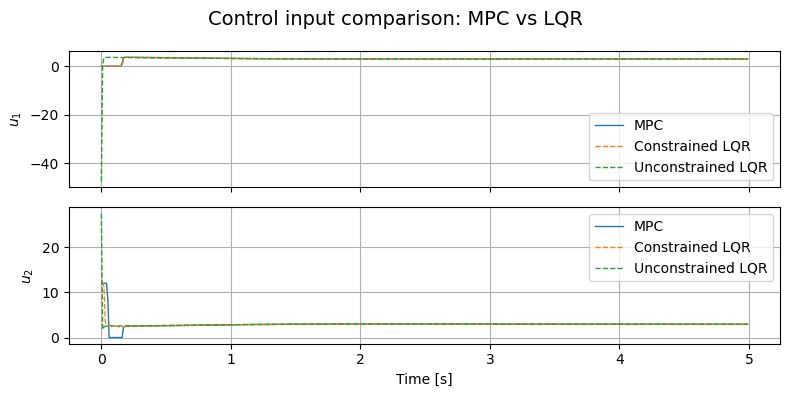

In [6]:
from control import dare
from simulation import simulate_lqr,plot_mpc_vs_lqr_states


Q = np.array([[100, 0., 0., 0., 0., 0.], 
              [0., 100.0, 0., 0., 0., 0.], 
              [0., 0., 100.0, 0., 0., 0.], 
              [0., 0., 0., 100.0, 0., 0.], 
              [0., 0., 0., 0., 100.0, 0.], 
              [0., 0., 0., 0., 0., 1000.0]])
    
R = np.array([[0.01, 0.],[0., 0.01]])

P_inf, _, K_inf = dare(Ad, Bd, Q, R)
K_inf = -K_inf
K = K_inf

x0=np.array([0.5,0, 0.5, 0, np.deg2rad(20), np.deg2rad(1)])#outside terminal set
#x0=np.array([0.01,0, 0.01, 0, 0, 0])#inside terminal set
N_sim = 500

# unconstraned LQR
x_hist_lqru, u_hist_lqru, cumulative_costs_lqru = simulate_lqr(
    Ad, Bd, Q, R, K, x0, x_eq, u_eq, 
    N_sim, lb_u, ub_u, dt=dt,
    apply_constraint=False
)

# constraned LQR
x_hist_lqrc, u_hist_lqrc, cumulative_costs_lqrc = simulate_lqr(
    Ad, Bd, Q, R, K, x0, x_eq, u_eq, 
    N_sim, lb_u, ub_u, dt=dt,
    apply_constraint=True
)


N = 20
N_sim = 500
dt = 0.01


A_inf, b_inf,P_inf, K = compute_terminal_set(
    Ad, Bd,
    lb_x_tilde, ub_x_tilde,
    lb_u_tilde, ub_u_tilde,
    Q, R,
    max_iter=50
)



x_hist, u_hist,cumulative_stage_costs=simulate_mpc_regulation(N, N_sim, x0, x_eq, u_eq,
                                        Ad, Bd, Q, R, P_inf,
                                        lb_u, ub_u,
                                        lb_x, ub_x,
                                        A_inf, b_inf)



time = np.arange(N_sim ) * dt
plt.figure(figsize=(8, 4))
plt.plot(time,cumulative_stage_costs, label="MPC ", alpha=1)
plt.plot(time,cumulative_costs_lqrc, label="Constraint LQR ", alpha=1,linestyle='--')
plt.plot(time,cumulative_costs_lqru, label="Unconstraint LQR ", alpha=1,linestyle='-.')

plt.xlabel('Time [s]')
plt.ylabel("Cumulative Cost")
plt.title("MPC vs Unconstrained and Constrained LQR (Cumulative Cost)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


plot_mpc_vs_lqr_states(
    x_hist, u_hist,
    x_hist_lqrc, u_hist_lqrc,
    x_hist_lqru, u_hist_lqru,
    N_sim=N_sim,
    dt=dt
)



Circular trajectory tracking

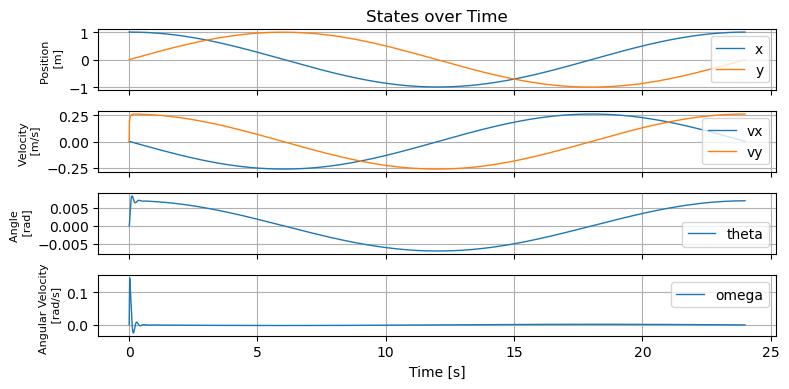

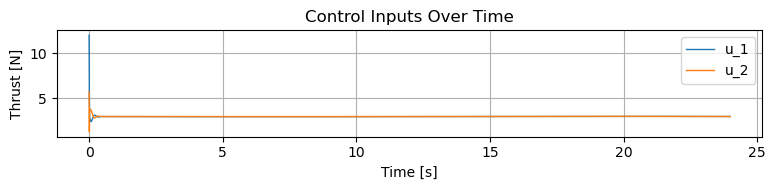

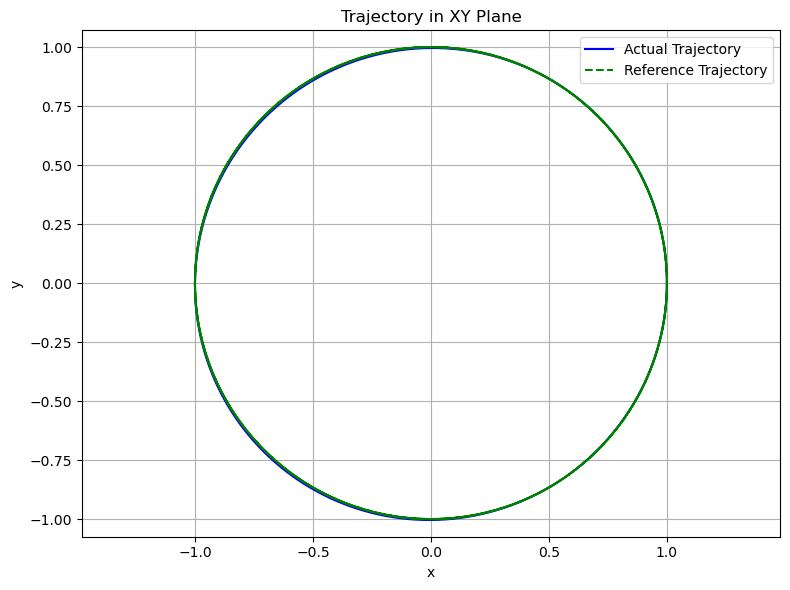

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQABxc1tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzA5NSBiYWVlNDAwIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMiAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI3
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
J+9liIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAADAAB1oWGAKYNX0WHAAAAD
AAmgAVAAowCUgK3ud/HqYZwATK65IRadikHw27dJzKopE6UIWrc1FUSqk64NH0246xSvyKrHO5Vy
lSmvfMC9/qT38SbqZxGcCYFlMHW+XHjCszJsLBs/6eQys6tlGcIiGLVc9Y8MLlO16LyHybrsKdAc
xHjvp/9NS5iEoXzwURxiLZrco3CDEv77ZzkBDMlAe/67uD9rPhUjIDfvNyXoPZbyph5YLcazj+C5
Ufcmvt7fr5Vm3yKbU/f42q5gNy1FKH1NrMqOnhHXj1Upd6nsbbCrtZIAMseRudXbi5XtaY3poI6p
MJ9yNQ8zp+70VMNf8AjD2D4Wd/m/vXk9e8NwHNrB9mzDjpl+1JQy8EcInS0L3ZPUIt350kuaSPf7
3Noq99w2xrYnYqBzPgK7sUOaBitNDbrgF5lkd88CYkEQuLtxkcFz8Qj64Jvbrm8fXRqHyyyWTLzM
9AKXl3snokAtJBoBF3eAta04Kh/HIDFQSTlKQBsUj8YEmmaqw9OFuXwcZhMAXtQnhAGilnVy5lx7
86+VKTRSXE5k5ho5V1xfVagfCA73nEG7D3Qmoig8R/7visc5BU/VJ9vGOsHr63MtIC2RkJOdE7lE
KR5mL6WkmAQZmn7+265PAjzIe1ePpUUC4Acp4W+EI2Eia8ciOQViNSu92Z0sp8NQHqX03niKI6xB
b7FlbwRSKE5TzK8GS2za6/9ACUVeIRiwG2YDubiYOh85IA9tv6HpUucpTENqYb7SVrYG/wsSbHsC
m6ngdX88Xmy86jF6/znHzcm3xeToJWvipr5eYmPsO9ETPkDUo+n21HI/+EOkuwJ5bksH/pCFPON3
6/Rx8ces/XnnHjaX19kwJGIEn27wgpMNX9p5kmnBtnRUL7Z1mafwTtJpfBQACn/nU9NijnkgisE7
qx1p5oMii+v/7dmQl2syjBL5Vu1Z7VLEqCrcXZ93ROAvf9aKK4x+2Fzzp+LAajeCi8otzBkwOJwp
diTSt1slF5qMALj+MszJg28gajn19MoAE7R6BzefiJBP+tM/1jTH+Vq3WHZXcjm22izlbaVfQpJa
4+yIcDYmNBJtFpcFcYdegZ7sGDJe2glo8v0mkfB/TRE5rtv596mIyKAaJpldGc/j5/YycRmH+T5R
6LJ93zss7O0ZSy1r+C+Yyp18UYjppfnNqOexpI7gzj1GJClmO9CvcYH0ZtOUElOmHtPB0LZzqKIi
599GJGf9Hc29EDmpzdw5TuI0PVQQL7R9ZA3ygYUI1YoA9Gfx6nbrBM8EIq3Bso68vbmJ/aQmRgfo
e6+LX8DzYsejuDZk+qCzT5/vZbPjGih1oASp5AX2Y5V/8nsKhwind8Szwe7An/Xh2OBCtZ57ZdM0
g7M+RlFhor4r0b95dmlf9wmjxP+qEsXIG9jQP6DbNXEU7R5Wjv2CtJIqhyYVZNy8fkJFuWi5Hy6l
SpgoXP6w3qEucKNwwjeMt2+ALuyt3BZK0YbKuY+GYNBZ7Cmf8wHZLoXyV40+X5MfcOMOzQjS482e
C/cxyp3c9AEyFnJj+CgU2sK33+WOZxKbd2HHgT7MeykiiGzZ7W37F3o6VqIwuAd8R3t9BafxHa6P
MgxbVmWo4WzoBK4orJORMGWZ+E8hj1GgWj3Mpivd7KUKu3xalQ2M7sPYngbSAsuW9rLLkCjBb1be
dHtXCEmgFPwUiGAHVMPvtCIjtCmCDsTC75SiEcxwf+qs4BHhnX6p9DjBKXBk+oUnVxOUh4XFlq+e
/IajCOdymeRwrvFt1/QXyITSr8MgHv2ie9r6SHQeG+IK9ld6JqDFLyDQtwZL45Ldv29x1TPjGWjW
hpFc2dNNq4w209WXDGtT/fOOyRogbHLGLqRfsJcIUPzs8ldiXfnkMOxbKC2Yy6f6cq6IWSHmT4hc
Wxn7So+skzOgnr14DySdRwE+nBl4AE66xw6qcBDR5grjVQ4wHFbwjGeSGSNgEV9eR5ijEU+pp3RR
CFnNAWM6rlODaF3Wh4ZAKPsxJJib8hWfvZByxeNBnqdFyjDxBYJ/WkYRZhyyd4+IiG30+n//nD59
i+YsRUNUkgzsy7eZlsAyxlUGi20ADUNRsfGKoC0nvWpbV6Df4/e0bWAtNV1y3LDEPIwfQy6vUsnR
c88lAmBFKPhKWw1mTXsTysxIvQ7eb/gdpGZGye7ZkCqHVa8gLBuVT38mPOBPGEu4PDXBPCnoDcFB
D6Xb31zS8cARYzil3z4ikuMpOJRNn80mZG/WSgGRS7rX7sRV+lOIYgc3KQw5JiH34RAeGe1ypdz8
3DcDpxeyjvNAFldVtfH85AVB1g0f801TPNcrLiyPdUE9WeI/WXfxGUaImNK1UrbCSKomgDAzfCxl
iVBRM/1/8XBrx2doWd12yBznPp+2l7NzqFhM4aPtiPhqa6pDNQdJTHQVf/+W9Wp8ge+bWfaGP/K6
y++87+H3w/FX1LkCoUZpEemB1nM6eOch1qKfBBHHITe0NYWKqiDcmfQyIdUYBTfboRE+/2eGcKED
RrD5uYQPD50uPnbD85yYlfpsLOU6Rw8tgNIFreoZ7LGazmza5Re+Ob3NzWzYuTy19iSWrGYwi0L/
6mR6xiuhJzNoPifClBZ53APrvgMlwyavsQ1COkl0Mvmwwa0xtcY3rA1cgEZMb7xJkSgSE76HHHH2
2zOrun3Uev5ECLC/4C7TOUIkIHJRIzMOYfx0R8WU7L+aAx6EuK1Q1rf+UIBOCJX4aW7HNetYTlB/
UxYszbbXns6k+W84g94361ghqeFdCADf/2M4RoFf/6yvWaoVHw+QRjq3Vz5KENFLvevkqsJltbyx
qbl3nR96mUfuu60kIv7IF

In [7]:
from simulation import generate_reference_circle_trajectory,simulate_mpc_tracking,plot_xy_trajectory
from controllers import solve_OTS_tracking
from planar_quadrotor import animate_robot_with_trail

x_ref_all = generate_reference_circle_trajectory(2400, Ad.shape[0])
x_ref_all = np.tile(x_ref_all, 3)



Q = np.array([[10e9, 0., 0., 0., 0., 0.], 
                  [0., 50.0, 0., 0., 0., 0.], 
                  [0., 0., 10e9, 0., 0., 0.], 
                  [0., 0., 0., 50.0, 0., 0.], 
                  [0., 0., 0., 0., 50, 0.], 
                  [0., 0., 0., 0., 0., 50.0]])
    
R = np.array([[0.001, 0.],[0., 0.001]])


N=6
N_sim=2400
x0 = np.array([1, 0, 0, 0, 0, 0]) 
#x0 = np.array([1.2, 0, -0.25, 0, 0, 0]) 

C = np.array([
    [1, 0, 0, 0, 0, 0],  # x
    [0, 1, 0, 0, 0, 0],  # vx
    [0, 0, 1, 0, 0, 0],  # y
    [0, 0, 0, 1, 0, 0]   # vy 
])



H = np.array([
    [1, 0, 0, 0],  # select x
    [0, 0, 1, 0],  # select y
])


dim_x = Ad.shape[0]
dim_u = Bd.shape[1]

x_ref_hist = np.zeros((N_sim+N+2, dim_x))
u_ref_hist = np.zeros((N_sim+N+2, dim_u))


for t in range(N_sim+N+2):
    

    yset=x_ref_all[:, t]
    yset=yset[:4].reshape(-1,1)
    x_ref_now, u_ref_now=solve_OTS_tracking(H, C, Ad, Bd, yset)
    

    x_ref_hist[t, :] = x_ref_now
    u_ref_hist[t, :] = u_ref_now



x_hist, u_hist=simulate_mpc_tracking(Ad, Bd, Q, R, N_sim, N, x0, x_eq, u_eq,
                           lb_u, ub_u, lb_x, ub_x,
                           x_ref_hist, u_ref_hist,
                           )

plot_mpc_regulation(x_hist, u_hist, N_sim, dt)
plot_xy_trajectory(x_hist, x_ref_all)
animate_robot_with_trail(x_hist.T, u_hist.T, dt=0.01, trail_color='m', trail_lw=1,x_ref_all=x_ref_all)


Piecewise static trajectory tracking

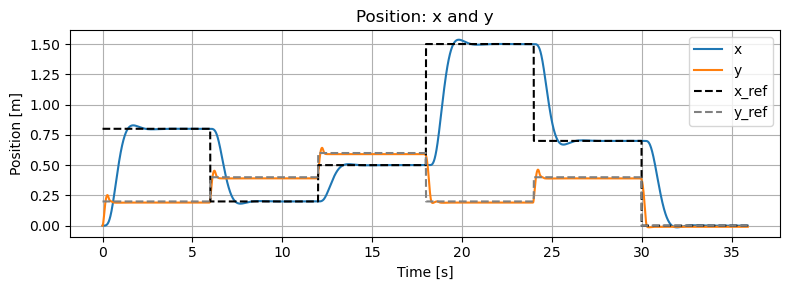

In [8]:

ref1 = np.array([[0.8, 0.0, 0.2, 0.0, 0.0, 0.0]]).T  
ref2 = np.array([[0.2, 0.0, 0.4, 0.0, 0.0, 0.0]]).T
ref3 = np.array([[0.5, 0.0, 0.6, 0.0, 0.0, 0.0]]).T
ref4 = np.array([[1.5, 0.0, 0.2, 0.0, 0.0, 0.0]]).T  
ref5 = np.array([[0.7, 0.0, 0.4, 0.0, 0.0, 0.0]]).T
ref6 = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T


x_ref_all = np.hstack([
    np.tile(ref1, (1, 600)),
    np.tile(ref2, (1, 600)),
    np.tile(ref3, (1, 600)),
    np.tile(ref4, (1, 600)),
    np.tile(ref5, (1, 600)),
    np.tile(ref6, (1, 600)),
]) 

Q = 0.01*np.array([[1.2e3, 0., 0., 0., 0., 0.], 
                  [0., 100.0, 0., 0., 0., 0.], 
                  [0., 0., 6e4, 0., 0., 0.], 
                  [0., 0., 0., 1e2, 0., 0.], 
                  [0., 0., 0., 0., 100, 0.], 
                  [0., 0., 0., 0., 0., 100.0]])

R = np.array([[1e-3, 0.],[0., 1e-3]])


dim_x = Ad.shape[0]
dim_u = Bd.shape[1]
N=5
N_sim=3590

x_ref_hist = np.zeros((N_sim+N+2, dim_x))
u_ref_hist = np.zeros((N_sim+N+2, dim_u))



x0 = np.array([0, 0, 0, 0, 0, 0]) 



for t in range(N_sim+N+2):
    

    yset=x_ref_all[:, t]
    yset=yset[:4].reshape(-1,1)
    x_ref_now, u_ref_now=solve_OTS_tracking(H, C, Ad, Bd, yset)
    

    x_ref_hist[t, :] = x_ref_now
    u_ref_hist[t, :] = u_ref_now



x_hist, u_hist=simulate_mpc_tracking(Ad, Bd, Q, R, N_sim, N, x0, x_eq, u_eq,
                           lb_u, ub_u, lb_x, ub_x,
                           x_ref_hist, u_ref_hist,
                           )



time = np.arange(N_sim + 1) * dt 
plt.figure(figsize=(8, 3))
plt.plot(time, x_hist[:, 0], label='x')
plt.plot(time, x_hist[:, 2], label='y')
plt.plot(time, x_ref_all[0,0:N_sim + 1], label='x_ref',color='black', linestyle='--')
plt.plot(time, x_ref_all[2,0:N_sim + 1], label='y_ref',color='gray', linestyle='--')


plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Position: x and y')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()



Augmented system, observability checking, and observer gain design

In [9]:
from controllers import construct_augmented_system_with_observability_check,design_observer_gain

dim_x = Ad.shape[0]
dim_u = Bd.shape[1]
dim_d = 2  # wind disturbance，acts on vx and vy


C = np.array([
    [1, 0, 0, 0, 0, 0],  # x
    [0, 1, 0, 0, 0, 0],  # vx
    [0, 0, 1, 0, 0, 0],  # y
    [0, 0, 0, 1, 0, 0]   # vy
])


# disturbance doesn't influence y
C_dist = np.zeros((C.shape[0], dim_d))  # 4x2

#   disturbance input matrix Bd_dist
Bd_dist = np.zeros((dim_x, dim_d))
Bd_dist[1, 0] = 1.0  # d1 acts on vx
Bd_dist[3, 1] = 1.0  # d2 acts on vy


A_aug, B_aug, C_aug, observable = construct_augmented_system_with_observability_check(
    Ad=Ad,
    Bd=Bd,
    C=C,
    dim_d=2
)

eigenplace = np.array([0.62, 0.75, 0.8, 0.65, 0.85,0.6, 0.5, 0.55])


L, Lx, Ld = design_observer_gain(
    A_aug,
    C_aug,
    eigenplace,
    dim_x
)




Rank of observability matrix G: 8
Expected rank: 8
System is observable.


Disturbance rejection

<>:74: SyntaxWarning: invalid escape sequence '\D'
<>:74: SyntaxWarning: invalid escape sequence '\D'
C:\Users\xianguhe888\AppData\Local\Temp\ipykernel_9248\3261700418.py:74: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("Wind disturbance \n [$\Delta$v, m/s]")


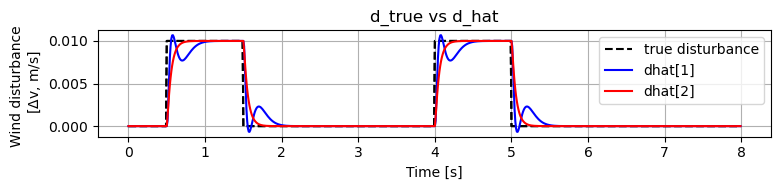

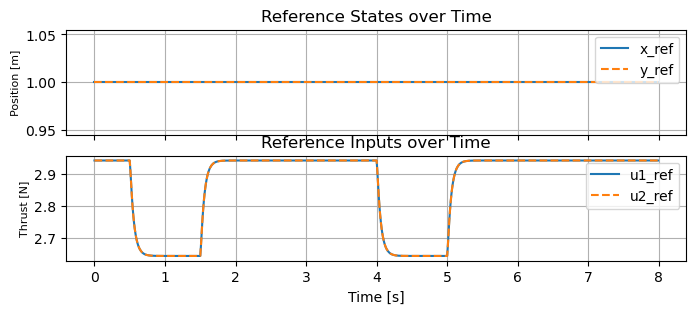

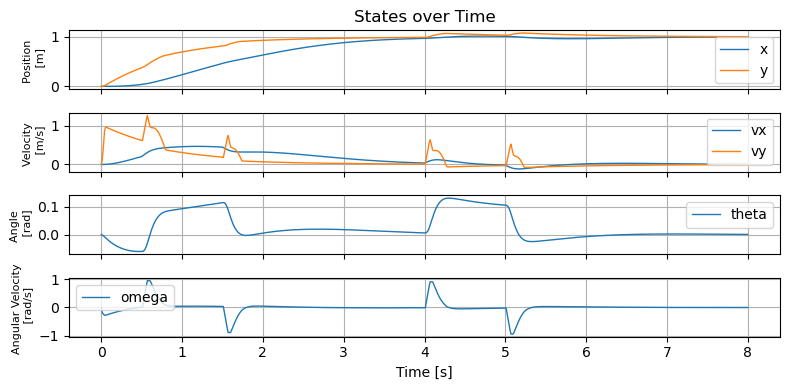

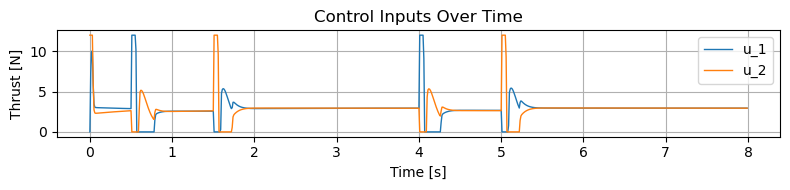

In [10]:
from simulation import simulate_mpc_disturbance



ps = np.ones(1000)
ps[:50] = 0
ps[50:150] *= 0.01
ps[150:400] *= 0
ps[400:500]=0.01
ps[500:]=0
ps = np.vstack([ps, ps])   


dt=0.01
Bp =Bd_dist


Q = np.array([[100.0, 0., 0., 0., 0., 0.], 
              [0., 100.0, 0., 0., 0., 0.], 
              [0., 0., 100.0, 0., 0., 0.], 
              [0., 0., 0., 100.0, 0., 0.], 
              [0., 0., 0., 0., 100.0, 0.], 
              [0., 0., 0., 0., 0., 1000.0]])
    
R = np.array([[0.01, 0.],[0., 0.01]])



A_inf, b_inf,P_inf, K = compute_terminal_set(
    Ad, Bd,
    lb_x_tilde, ub_x_tilde,
    lb_u_tilde, ub_u_tilde,
    Q, R,
    max_iter=50
)


H = np.array([
    [1, 0, 0, 0],  # select x
    [0, 0, 1, 0],  # select y
])


N_sim=800
N=10
x0 = np.array([0., 0., 0.,0., 0.,0.])
yset = np.array([1., 0., 1.,0.])


x_hist, u_hist, xhat_hist, dhat_hist, xs_hist, us_hist=simulate_mpc_disturbance(
                                                                                Ad, Bd, Q, R, P_inf, A_inf, b_inf,
                                                                                C, H,
                                                                                lb_x, ub_x, lb_u, ub_u,
                                                                                x0, yset, N_sim, N,
                                                                                Bp, ps,    
                                                                                Lx, Ld,    
                                                                                Bd_dist, C_dist, 
                                                                                dt=0.01
                                                                            )




time = np.arange(N_sim) * dt
plt.figure(figsize=(8, 2))
ps=ps[:, :N_sim]

for i in range(dhat_hist.shape[1]):
    plt.plot(time , ps[i], 'k--', label=f'true disturbance' if i == 0 else None)   
plt.plot(time, dhat_hist[:, 0], 'b-', label='dhat[1]' )  
plt.plot(time, dhat_hist[:, 1], 'r-', label='dhat[2]')

plt.xlabel("Time [s]")
plt.ylabel("Wind disturbance \n [$\Delta$v, m/s]")
plt.title("d_true vs d_hat")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 1, figsize=(8, 3), sharex=True)
time = np.arange(N_sim) * dt
axs[0].plot(time, xs_hist[:, 0], label='x_ref', linewidth=1.5)
axs[0].plot(time, xs_hist[:, 2], label='y_ref', linewidth=1.5,linestyle='--')
axs[0].set_ylabel('Position [m]',fontsize=8)
axs[0].set_title('Reference States over Time')
axs[0].legend()
axs[0].grid(True)


time2 = np.arange(N_sim) * dt
axs[1].plot(time2, us_hist[:, 0], label='u1_ref', linewidth=1.5)
axs[1].plot(time2, us_hist[:, 1], label='u2_ref', linewidth=1.5,linestyle='--')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Thrust [N]',fontsize=8)
axs[1].set_title('Reference Inputs over Time')
axs[1].legend()
axs[1].grid(True)


plot_mpc_regulation(x_hist, u_hist, N_sim, dt)


